<a href="https://colab.research.google.com/github/Edwardha92/SIP2/blob/master/one_Layer_CAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
import time

In [4]:
from google.colab import files
uploaded = files.upload()

Saving lena100x100.jpg to lena100x100.jpg


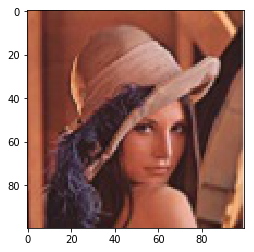

In [5]:

#load Image
image = mpimg.imread('lena100x100.jpg')
#image = mpimg.imread('lena10x10.jpg')
image = image/255
plt.imshow(image)
xImage, yImage, zImage = image.shape


In [0]:
#parameter
stride = 3
padding = 0
learnRate = 0.01

In [0]:
np.random.seed(1)
#Filter and bias
xWeight = 3
yWeight = 3
zWeight = 3
numFilter = 10
weights = np.random.standard_normal(size=(xWeight,yWeight,zWeight,numFilter))*0.5
biasIn = np.random.standard_normal(size=(1,1,1,numFilter))*0.5
biasOut = np.random.standard_normal(size=(1,1,zWeight))*0.5

In [0]:
#initial feature map
feature_map = np.zeros((int(xImage/stride), int(yImage/stride), numFilter))
#initial reconstructed Image
reImage = np.zeros((xImage, yImage, zImage))

In [0]:
#activation function
def relu(Z):
    """
    the activation function Relu (rectifier linear unit)
    return the value of the input X if it's larger than 0
    """
    Z=np.maximum(0,Z)   
    return Z

In [0]:
#convolution
def conv(image,weights,biasIn,stride):
    
    xWeight,yWeight,zWeight,numFilter = weights.shape
    summe = np.zeros((1,1,numFilter)) 
    for z in range(numFilter):
        for xx in range(xWeight):
            for yy in range(yWeight):
                for zz in range(zWeight):
                    summe[:,:,z] += image[xx,yy,zz]*weights[xx,yy,zz,z]
        summe+= biasIn[:,:,:,z]
    feature_map = summe    
    feature_map = relu(feature_map)
    return feature_map

In [0]:
#deconvolution
def deconv(feature_map, weights,biasOut, stride):

    xWeight,yWeight,zWeight,numFilter = weights.shape
    summe = np.zeros((xWeight,yWeight,zWeight))
    for xx in range(xWeight):
        for yy in range(yWeight):
            for zz in range(zWeight):
                for z in range(numFilter):            
                    summe[xx,yy,zz] += feature_map[:,:,z]*weights[xx,yy,zz,z]
                summe[xx,yy,zz] += biasOut[:,:,zz]
                reImage = relu(summe)
    return reImage

In [0]:
#contrastive Divergence
def contrastiveDivergence(image, weights, feature_map, reImage, stride, learnRate):
    
    xWeight,yWeight,zWeight,numFilter = weights.shape
    summe = np.zeros((xWeight,yWeight,zWeight,numFilter)) 
    for z in range(numFilter):
        for xx in range(xWeight):
            for yy in range(yWeight):
                for zz in range(zWeight):
                    summe[xx,yy,zz,z] -= learnRate* (reImage[xx,yy,zz]-image[xx,yy,zz])*feature_map[:,:,z]
    delta_weights = summe
    return delta_weights

In [0]:
#training
def trainingLayer(image, weights, feature_map, reImage, biasIn, biasOut, stride, learnRate):
    for y in range(0,xImage-xWeight,stride):
        for x in range(0,yImage-yWeight,stride):
            image_region = image[x:x+stride,y:y+stride,:]
            feature_map_region = feature_map[int(x/stride),int(y/stride),:]
            reImage_region = reImage[x:x+stride, y:y+stride,:]
            feature_map_region = conv(image_region,weights, biasIn,stride)
            reImage_region = deconv(feature_map_region,weights, biasOut, stride)
            delta_weights = contrastiveDivergence(image_region, weights, feature_map_region, reImage_region, stride, learnRate)
            feature_map[int(x/stride),int(y/stride),:] = feature_map_region
            reImage[x:x+stride, y:y+stride,:] = reImage_region
            weights += delta_weights
    return  weights

In [0]:
#convoltuiton Layer
def convolutionLayer(image, weights, biasIn, feature_map, stride):
    for y in range(0,xImage-xWeight,stride):
        for x in range(0,yImage-yWeight,stride):
            image_region = image[x:x+stride,y:y+stride,:]
            feature_map_region = feature_map[int(x/stride),int(y/stride),:]
            feature_map_region = conv(image_region,weights,biasIn,stride)
            feature_map[int(x/stride),int(y/stride),:] = feature_map_region
    return feature_map


In [0]:
#deconvolution Layer
def deconvolutionLayer(image, feature_map, reImage, weights, biasOut, stride):
    for y in range(0,xImage-xWeight,stride):
        for x in range(0,yImage-yWeight,stride):
            image_region = image[x:x+stride,y:y+stride,:]
            feature_map_region = feature_map[int(x/stride),int(y/stride),:]
            reImage_region = reImage[x:x+stride, y:y+stride,:]
            feature_map_region = conv(image_region,weights,biasIn,stride)
            reImage_region = deconv(feature_map_region,weights,biasOut, stride)
            reImage[x:x+stride, y:y+stride,:] = reImage_region
    return reImage

In [16]:
start = time.time()
#training Filter    
for i in range(50):
    weights = trainingLayer(image, weights, feature_map, reImage, biasIn, biasOut, stride,learnRate)
end = time.time()
print('Training time:',end-start)

Training time: 174.82295894622803


In [0]:
feature_map = convolutionLayer(image, weights, biasIn, feature_map, stride)
reImage = deconvolutionLayer(image, feature_map, reImage, weights, biasOut, stride)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


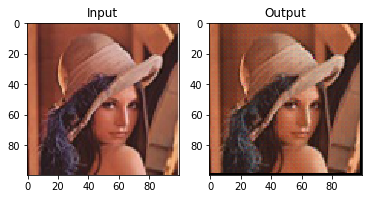

In [18]:
#plotting input and output
plt.subplot(1, 2, 1)
plt.title("Input")
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.title("Output")
plt.imshow(reImage)

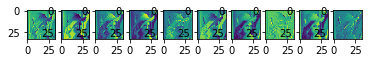

In [19]:
#plotting feature maps
plt.subplot(1, 10, 1)
#plt.title("feature_map 01")
plt.imshow(feature_map[:,:,0])
plt.subplot(1, 10, 2)
#plt.title("feature_map 02")
plt.imshow(feature_map[:,:,1])
plt.subplot(1, 10, 3)
#plt.title("feature_map 03")
plt.imshow(feature_map[:,:,2])
plt.subplot(1, 10, 4)
#plt.title("feature_map 04")
plt.imshow(feature_map[:,:,3])     
plt.subplot(1, 10, 5)
#plt.title("feature_map 05")
plt.imshow(feature_map[:,:,4])
plt.subplot(1, 10, 6)
#plt.title("feature_map 06")
plt.imshow(feature_map[:,:,5])
plt.subplot(1, 10, 7)
#plt.title("feature_map 07")
plt.imshow(feature_map[:,:,6])
plt.subplot(1, 10, 8)
#plt.title("feature_map 08")
plt.imshow(feature_map[:,:,7])
plt.subplot(1, 10, 9)
#plt.title("feature_map 09")
plt.imshow(feature_map[:,:,8])
plt.subplot(1, 10, 10)
#plt.title("feature_map 10")
plt.imshow(feature_map[:,:,9])

In [20]:
print('min Filter:', np.min(weights))
print('max Filter:', np.max(weights))

min Filter: -0.47567461506041253
max Filter: 0.5815433435373988
